In [15]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from collections import Counter
from itertools import combinations
import time

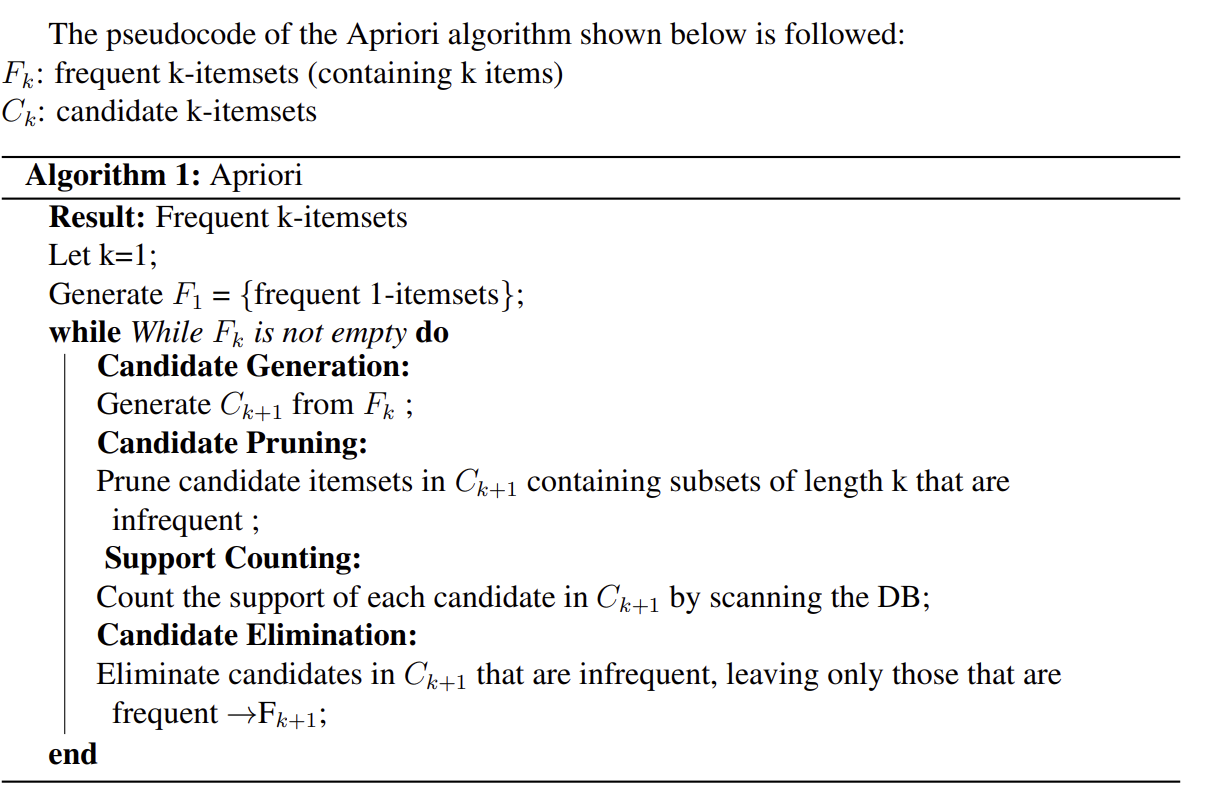

# Load data

In [16]:
from google.colab import drive
drive.mount('/content/drive')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
cityA_data = pd.read_csv('/content/drive/MyDrive/Y3S1/SC4020 Data Analytics & Mining/Project 2 Data/POIdata_cityA.csv')
cityB_data = pd.read_csv('/content/drive/MyDrive/Y3S1/SC4020 Data Analytics & Mining/Project 2 Data/POIdata_cityB.csv')
cityC_data = pd.read_csv('/content/drive/MyDrive/Y3S1/SC4020 Data Analytics & Mining/Project 2 Data/POIdata_cityC.csv')
cityD_data = pd.read_csv('/content/drive/MyDrive/Y3S1/SC4020 Data Analytics & Mining/Project 2 Data/POIdata_cityD.csv')

# Display the first few rows of the dataset
print(cityA_data.head())
print(cityB_data.head())
print(cityC_data.head())
print(cityD_data.head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   x  y  category  POI_count
0  1  1        74          4
1  1  1        48          4
2  1  1        79          2
3  1  1        69          2
4  1  1        73          1
   x  y  category  POI_count
0  1  1        79          2
1  1  1        84          1
2  1  2        82          1
3  1  3        54          1
4  1  3        74          1
   x    y  category  POI_count
0  1   35        48          1
1  1   38        48          1
2  1   45        48          1
3  1   45        47          1
4  1  108        46          1
   x   y  category  POI_count
0  1  11        46          1
1  1  55        60          2
2  1  55        48          1
3  1  56        68          1
4  1  56        75          1


# 1. Data Preparation for Apriori Algorithm

In [18]:
# Group the data by grid cells and collect all POI categories as a list for each cell
def prepare_data_for_apriori(data):
    baskets = data.groupby(['x', 'y'])['category'].apply(list).reset_index()
    return baskets

cityA_baskets = prepare_data_for_apriori(cityA_data)
cityB_baskets = prepare_data_for_apriori(cityB_data)
cityC_baskets = prepare_data_for_apriori(cityC_data)
cityD_baskets = prepare_data_for_apriori(cityD_data)

# Check the organized data structure
print(cityA_baskets.head())
print(cityB_baskets.head())
print(cityC_baskets.head())
print(cityD_baskets.head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   x  y                                  category
0  1  1              [74, 48, 79, 69, 73, 59, 58]
1  1  2                      [61, 80, 48, 76, 60]
2  1  3  [74, 81, 48, 82, 54, 56, 58, 73, 36, 60]
3  1  4              [73, 81, 63, 48, 79, 74, 69]
4  1  5              [74, 60, 48, 69, 62, 76, 79]
   x  y      category
0  1  1      [79, 84]
1  1  2          [82]
2  1  3      [54, 74]
3  1  6      [58, 74]
4  1  7  [61, 73, 56]
   x    y  category
0  1   35      [48]
1  1   38      [48]
2  1   45  [48, 47]
3  1  108      [46]
4  1  128  [74, 45]
   x   y                          category
0  1  11                              [46]
1  1  55                          [60, 48]
2  1  56           [68, 75, 41, 14, 82, 3]
3  1  57  [69, 41, 58, 81, 61, 76, 74, 54]
4  1  58          [69, 74, 41, 79, 62, 73]


In [20]:
# Count the number of unique grids (unique x, y pairs) for each city
num_grids_cityA = cityA_data[['x', 'y']].drop_duplicates().shape[0]
num_grids_cityB = cityB_data[['x', 'y']].drop_duplicates().shape[0]
num_grids_cityC = cityC_data[['x', 'y']].drop_duplicates().shape[0]
num_grids_cityD = cityD_data[['x', 'y']].drop_duplicates().shape[0]

# Display the results
print(f"Number of unique grids in City A: {num_grids_cityA}")
print(f"Number of unique grids in City B: {num_grids_cityB}")
print(f"Number of unique grids in City C: {num_grids_cityC}")
print(f"Number of unique grids in City D: {num_grids_cityD}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of unique grids in City A: 20146
Number of unique grids in City B: 9124
Number of unique grids in City C: 3251
Number of unique grids in City D: 10988


In [26]:
# Define support percentages for experimentation
support_percentages = [0.005, 0.01, 0.02]  # 0.5%, 1%, 2%

# Define unique grid counts for each city
unique_grids = {
    "City A": 20146,
    "City B": 9124,
    "City C": 3251,
    "City D": 10988
}

# Compute minimum support counts for each city
min_support_counts = {city: [int(perc * grids) for perc in support_percentages]
                      for city, grids in unique_grids.items()}

# Print the calculated minimum support counts
for city, counts in min_support_counts.items():
    print(f"{city} - Minimum Support Counts for 0.5%, 1%, and 2% of unique grids: {counts}")


City A - Minimum Support Counts for 0.5%, 1%, and 2% of unique grids: [100, 201, 402]
City B - Minimum Support Counts for 0.5%, 1%, and 2% of unique grids: [45, 91, 182]
City C - Minimum Support Counts for 0.5%, 1%, and 2% of unique grids: [16, 32, 65]
City D - Minimum Support Counts for 0.5%, 1%, and 2% of unique grids: [54, 109, 219]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 2.1 Generate k-itemsets

In [6]:
def get_itemsets(baskets, num):
    """
    Generate all possible k-itemsets from the baskets and count their frequency.
    """
    itemsets = []
    for basket in baskets['category']:
        if len(basket) >= num:
            itemsets.extend(combinations(basket, num))
    return Counter(itemsets)



# 2.2 Candidate Generation

In [7]:
def generate_candidates(frequent_itemsets, k):
    """
    Generate candidate (k+1)-itemsets from frequent k-itemsets.
    """
    candidates = set()
    items = list(frequent_itemsets.keys())

    for i in range(len(items)):
        for j in range(i + 1, len(items)):
            if items[i][:k-1] == items[j][:k-1]:
                candidate = tuple(sorted(set(items[i]) | set(items[j])))
                if len(candidate) == k + 1:
                    candidates.add(candidate)

    return list(candidates)


# 2.3 Candidate Pruning

In [8]:
def prune_candidates(candidates, infrequent_itemsets):
    """
    Prune candidates that contain infrequent subsets.
    """
    pruned_candidates = []
    for candidate in candidates:
        is_frequent = True
        subsets = combinations(candidate, len(candidate) - 1)

        for subset in subsets:
            if subset in infrequent_itemsets:
                is_frequent = False
                break

        if is_frequent:
            pruned_candidates.append(candidate)

    return pruned_candidates


#  Apriori algorithm

In [9]:
def apriori_algorithm(baskets, min_support=2):
    """
    Full implementation of the Apriori algorithm.
    """
    k = 1  # Start with 1-itemsets
    frequent_itemsets = {}
    infrequent_itemsets = {}

    # Generate initial 1-itemsets
    current_itemsets = get_itemsets(baskets, k)
    frequent_itemsets[k] = {item: count for item, count in current_itemsets.items() if count >= min_support}
    infrequent_itemsets[k] = {item: count for item, count in current_itemsets.items() if count < min_support}

    # Loop until no more frequent itemsets can be generated
    while frequent_itemsets[k]:
        k += 1
        candidates = generate_candidates(frequent_itemsets[k - 1], k - 1)
        pruned_candidates = prune_candidates(candidates, infrequent_itemsets[k - 1])

        # Count the support for each pruned candidate
        candidate_counts = Counter()
        for basket in baskets['category']:
            for candidate in pruned_candidates:
                if set(candidate).issubset(set(basket)):
                    candidate_counts[candidate] += 1

        # Separate frequent and infrequent itemsets
        frequent_itemsets[k] = {item: count for item, count in candidate_counts.items() if count >= min_support}
        infrequent_itemsets[k] = {item: count for item, count in candidate_counts.items() if count < min_support}

    # Collect all frequent itemsets across different k values
    all_frequent_itemsets = {k: v for k_dict in frequent_itemsets.values() for k, v in k_dict.items()}
    return all_frequent_itemsets


In [10]:
def get_itemsets(baskets, num):
    """
    Generate all possible k-itemsets from the baskets and count their frequency.
    """
    itemsets = []
    for basket in baskets['category']:
        if len(basket) >= num:
            itemsets.extend(combinations(basket, num))
    return Counter(itemsets)

def generate_candidates(frequent_itemsets, k):
    """
    Generate candidate (k+1)-itemsets from frequent k-itemsets.
    """
    candidates = set()
    items = list(frequent_itemsets.keys())

    for i in range(len(items)):
        for j in range(i + 1, len(items)):
            if items[i][:k-1] == items[j][:k-1]:
                candidate = tuple(sorted(set(items[i]) | set(items[j])))
                if len(candidate) == k + 1:
                    candidates.add(candidate)

    return list(candidates)

def prune_candidates(candidates, infrequent_itemsets):
    """
    Prune candidates that contain infrequent subsets.
    """
    pruned_candidates = []
    for candidate in candidates:
        is_frequent = True
        subsets = combinations(candidate, len(candidate) - 1)

        for subset in subsets:
            if subset in infrequent_itemsets:
                is_frequent = False
                break

        if is_frequent:
            pruned_candidates.append(candidate)

    return pruned_candidates


In [11]:
def apriori_chunked(file_path, min_support=10, chunk_size=63):
    """
    Run the Apriori algorithm by processing the dataset in chunks.
    """
    frequent_itemsets = Counter()  # Store aggregated frequent itemsets

    # Loop through the dataset in 63 chunks
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        baskets = chunk.groupby(['x', 'y'])['category'].apply(list).reset_index()

        # Generate and accumulate frequent 1-itemsets for this chunk
        itemsets = get_itemsets(baskets, 1)
        frequent_itemsets.update(itemsets)

    # Filter out itemsets that do not meet the minimum support threshold
    frequent_itemsets = {item: count for item, count in frequent_itemsets.items() if count >= min_support}

    return frequent_itemsets


In [29]:

cityA_file = '/content/drive/MyDrive/Y3S1/SC4020 Data Analytics & Mining/Project 2 Data/POIdata_cityA.csv'
cityB_file = '/content/drive/MyDrive/Y3S1/SC4020 Data Analytics & Mining/Project 2 Data/POIdata_cityB.csv'
cityC_file = '/content/drive/MyDrive/Y3S1/SC4020 Data Analytics & Mining/Project 2 Data/POIdata_cityC.csv'
cityD_file = '/content/drive/MyDrive/Y3S1/SC4020 Data Analytics & Mining/Project 2 Data/POIdata_cityD.csv'



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
import time
min_support_valuesA = [100, 201, 402]
for min_support in min_support_valuesA:

    # City A
    print(f"\nProcessing City A with min support = {min_support}")
    start_time = time.time()
    frequent_itemsets_A = apriori_chunked(cityA_file, min_support=min_support, chunk_size=63)
    elapsed_time = time.time() - start_time

    # Print results
    print(f"Time taken: {elapsed_time:.5f} seconds")
    print(f"Number of frequent itemsets: {len(frequent_itemsets_A)}")
    print(f"Most frequent itemset: {max(frequent_itemsets_A.items(), key=lambda x: x[1])}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Processing City A with min support = 100
Time taken: 12.69561 seconds
Number of frequent itemsets: 78
Most frequent itemset: ((81,), 11263)

Processing City A with min support = 201
Time taken: 12.72191 seconds
Number of frequent itemsets: 74
Most frequent itemset: ((81,), 11263)

Processing City A with min support = 402
Time taken: 15.26949 seconds
Number of frequent itemsets: 68
Most frequent itemset: ((81,), 11263)


In [23]:
min_support_valuesB = [45, 91, 182]
for min_support in min_support_valuesB:

    # City B
    print(f"\nProcessing City B with min support = {min_support}")
    start_time = time.time()
    frequent_itemsets_B = apriori_chunked(cityB_file, min_support=min_support, chunk_size=63)
    elapsed_time = time.time() - start_time

    # Print results
    print(f"Time taken: {elapsed_time:.5f} seconds")
    print(f"Number of frequent itemsets: {len(frequent_itemsets_B)}")
    print(f"Most frequent itemset: {max(frequent_itemsets_B.items(), key=lambda x: x[1])}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Processing City B with min support = 45
Time taken: 3.85033 seconds
Number of frequent itemsets: 73
Most frequent itemset: ((74,), 3422)

Processing City B with min support = 91
Time taken: 3.42021 seconds
Number of frequent itemsets: 68
Most frequent itemset: ((74,), 3422)

Processing City B with min support = 182
Time taken: 3.18265 seconds
Number of frequent itemsets: 53
Most frequent itemset: ((74,), 3422)


In [27]:
min_support_valuesC = [16, 32, 65]
for min_support in min_support_valuesC:

    # City C
    print(f"\nProcessing City C with min support = {min_support}")
    start_time = time.time()
    frequent_itemsets_C = apriori_chunked(cityC_file, min_support=min_support, chunk_size=63)
    elapsed_time = time.time() - start_time

    # Print results
    print(f"Time taken: {elapsed_time:.5f} seconds")
    print(f"Number of frequent itemsets: {len(frequent_itemsets_C)}")
    print(f"Most frequent itemset: {max(frequent_itemsets_C.items(), key=lambda x: x[1])}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Processing City C with min support = 16
Time taken: 3.54253 seconds
Number of frequent itemsets: 78
Most frequent itemset: ((48,), 1858)

Processing City C with min support = 32
Time taken: 3.91126 seconds
Number of frequent itemsets: 78
Most frequent itemset: ((48,), 1858)

Processing City C with min support = 65
Time taken: 3.42294 seconds
Number of frequent itemsets: 70
Most frequent itemset: ((48,), 1858)


In [36]:
min_support_valuesD = [100, 201, 402]
for min_support in min_support_valuesD:

    # City C
    print(f"\nProcessing City D with min support = {min_support}")
    start_time = time.time()
    frequent_itemsets_D = apriori_chunked(cityD_file, min_support=min_support, chunk_size=63)
    elapsed_time = time.time() - start_time

    # Print results
    print(f"Time taken: {elapsed_time:.5f} seconds")
    print(f"Number of frequent itemsets: {len(frequent_itemsets_D)}")
    print(f"Most frequent itemset: {max(frequent_itemsets_D.items(), key=lambda x: x[1])}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Processing City D with min support = 100
Time taken: 5.85631 seconds
Number of frequent itemsets: 70
Most frequent itemset: ((74,), 3966)

Processing City D with min support = 201
Time taken: 4.20247 seconds
Number of frequent itemsets: 56
Most frequent itemset: ((74,), 3966)

Processing City D with min support = 402
Time taken: 4.15068 seconds
Number of frequent itemsets: 48
Most frequent itemset: ((74,), 3966)


In [37]:
import pandas as pd

# Define the updated results data for each city with updated City B data
data_updated = {
    "City": ["A", "A", "A", "B", "B", "B", "C", "C", "C", "D", "D", "D"],
    "Min Support": [100, 201, 402, 45, 91, 182, 16, 32, 65, 100, 201, 402],
    "Time Taken (s)": [12.69561, 12.72191, 15.26949, 3.85033, 3.42021, 3.18265, 3.54253, 3.91126, 3.42294, 5.85631, 4.20247, 4.15068],
    "Number of Frequent Itemsets": [78, 74, 68, 73, 68, 53, 78, 78, 70, 70, 56, 48],
    "Most Frequent Itemset": ["((81,), 11263)", "((81,), 11263)", "((81,), 11263)", "((74,), 3422)", "((74,), 3422)", "((74,), 3422)",
                              "((48,), 1858)", "((48,), 1858)", "((48,), 1858)", "((74,), 3966)", "((74,), 3966)", "((74,), 3966)"]
}

# Create DataFrame with updated data
results_df_updated = pd.DataFrame(data_updated)

# Separate tables for each city
results_city_a_updated = results_df_updated[results_df_updated["City"] == "A"].reset_index(drop=True)
results_city_b_updated = results_df_updated[results_df_updated["City"] == "B"].reset_index(drop=True)
results_city_c_updated = results_df_updated[results_df_updated["City"] == "C"].reset_index(drop=True)
results_city_d_updated = results_df_updated[results_df_updated["City"] == "D"].reset_index(drop=True)

# Display tables for each city with updated data
print("City A Frequent Itemset Analysis Results")
print(results_city_a_updated.to_string(index=False))

print("\nCity B Frequent Itemset Analysis Results")
print(results_city_b_updated.to_string(index=False))

print("\nCity C Frequent Itemset Analysis Results")
print(results_city_c_updated.to_string(index=False))

print("\nCity D Frequent Itemset Analysis Results")
print(results_city_d_updated.to_string(index=False))


City A Frequent Itemset Analysis Results
City  Min Support  Time Taken (s)  Number of Frequent Itemsets Most Frequent Itemset
   A          100        12.69561                           78        ((81,), 11263)
   A          201        12.72191                           74        ((81,), 11263)
   A          402        15.26949                           68        ((81,), 11263)

City B Frequent Itemset Analysis Results
City  Min Support  Time Taken (s)  Number of Frequent Itemsets Most Frequent Itemset
   B           45         3.85033                           73         ((74,), 3422)
   B           91         3.42021                           68         ((74,), 3422)
   B          182         3.18265                           53         ((74,), 3422)

City C Frequent Itemset Analysis Results
City  Min Support  Time Taken (s)  Number of Frequent Itemsets Most Frequent Itemset
   C           16         3.54253                           78         ((48,), 1858)
   C           32        

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
